In [1]:
# Data handling
import pandas as pd 
import numpy as np

# Clustering
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler

# Dimensionality reduction
from sklearn.decomposition import PCA


# Visualization
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.style as style
%matplotlib inline

import warnings
warnings.simplefilter("ignore")

In [2]:
def prepare_pca(n_components, data, kmeans_labels):
    """ prepare pca with n dimension
    """
    names = ['x', 'y', 'z']
    matrix = PCA(n_components=n_components).fit_transform(data)
    df_matrix = pd.DataFrame(matrix)
    df_matrix.rename({i:names[i] for i in range(n_components)}, axis=1, inplace=True)
    df_matrix['labels'] = kmeans_labels
    
    return df_matrix

def plot_3d(df, name='labels'):
    """ plot 3d scatter
    """
    iris = px.data.iris()
    fig = px.scatter_3d(df, x='x', y='y', z='z',color=name)
    fig.update_traces(marker=dict(size=3))
    fig.show()
    
    
def load_preprocess_data():
    """ Load and preprocess data
    """
    # load dataset
    df = pd.read_csv('data_credit_card_customer_seg.csv')
    
    # handle missing values by replace it by means
    df['CREDIT_LIMIT'].fillna(df['CREDIT_LIMIT'].mean(), inplace=True)
    df['MINIMUM_PAYMENTS'].fillna(df['MINIMUM_PAYMENTS'].mean(), inplace=True)
    
    # drop unnecessary column
    df.drop('CUST_ID', axis=1, inplace=True)
    
    return  df

df = load_preprocess_data()
df.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.206542,0.000000,12
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


## Data Normalization (min-max Normalization)

In [6]:
scaling = MinMaxScaler()
scaled_df = scaling.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df)

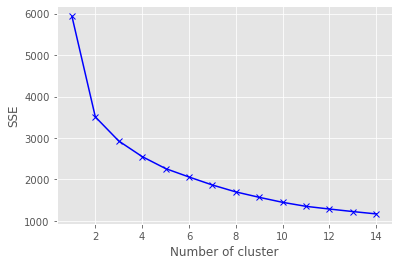

In [7]:
style.use('ggplot')

# Choosing the K value using elbow method 
sse = {}
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(scaled_df)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()),'bx-')
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

It's hard to find the elbow point of the curve, so we use silhouette score.

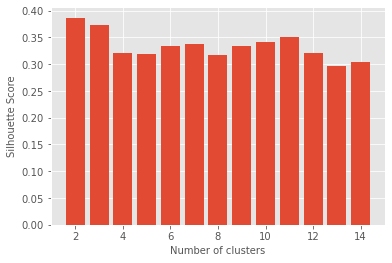

In [8]:
# silhouette score
silhouette_scores = []

for n_cluster in range(2, 15):
    silhouette_scores.append( 
        silhouette_score(scaled_df, KMeans(n_clusters = n_cluster).fit_predict(scaled_df))) 
    
# Plotting a bar graph to compare the results 
k = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14] 

plt.bar(k, silhouette_scores) 
plt.xlabel('Number of clusters', fontsize = 10) 
plt.ylabel('Silhouette Score', fontsize = 10) 
plt.show() 

Highest silhouette score is k = 2.

# Kmeans clustering

Let's visualize k=2,3

# k=2

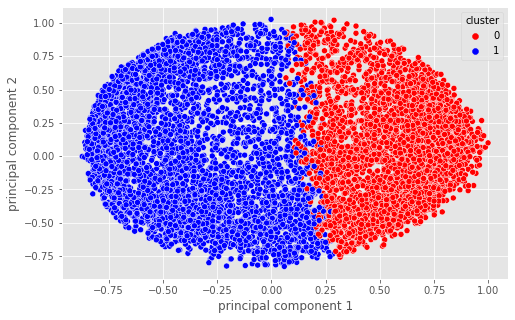

In [11]:
# Kmeans algorithm
kmean= KMeans(n_clusters=2)
kmean.fit(scaled_df)
labels=kmean.labels_

# feature scaling for visualization
scaler = StandardScaler() 
scaled = scaler.fit_transform(df) 

# Normalizing the Data 
normalized_df = normalize(scaled) 
  
# Converting the numpy array into a pandas DataFrame 
normalized_df = pd.DataFrame(normalized_df) 

# PCA to transform data to 2 dimensions for visualization
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(normalized_df)
principalDf = pd.DataFrame(data = principalComponents, columns=['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, pd.DataFrame({'cluster':labels})], axis = 1)

plt.figure(figsize=(8,5))
ax = sns.scatterplot( data=finalDf,x="principal component 1", y="principal component 2", hue="cluster",palette=['red','blue'])
plt.show()

In [ ]:
pca_df = prepare_pca(3, normalized_df, labels)
plot_3d(pca_df)

In [12]:
clusters=pd.concat([df, pd.DataFrame({'cluster':labels})], axis=1)
clusters['cluster'].value_counts()

1    5223
0    3727
Name: cluster, dtype: int64

In [13]:
clusters.groupby('cluster').mean()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
cluster,,,,,,,,,,,,,,,,,
0,1377.155466,0.945216,2022.291551,1140.561339,882.058758,435.716622,0.904476,0.362226,0.729487,0.058386,1.410786,30.633754,5093.069561,2182.150655,872.024203,0.270529,11.674805
1,1698.141161,0.828787,276.010463,201.310044,74.980362,1366.452347,0.194841,0.088451,0.103947,0.189917,4.560406,3.346927,4067.289360,1412.744014,858.628059,0.070359,11.404940


Text(0.5, 0, 'SEGMENTS')

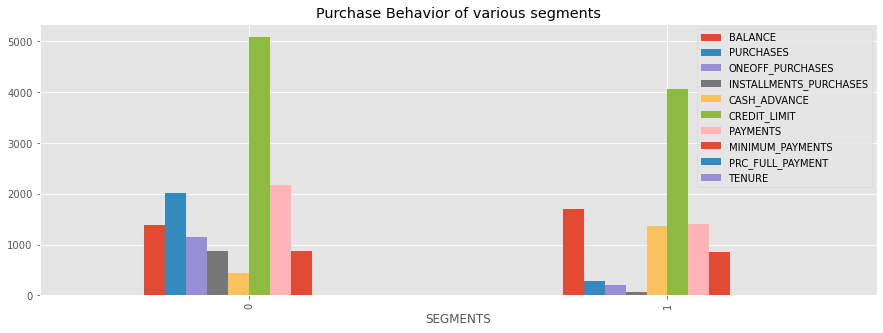

In [14]:
(clusters[['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES',
           'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE','CREDIT_LIMIT', 'PAYMENTS', 
           'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT','TENURE', 'cluster']]
 .groupby('cluster').mean().plot.bar(figsize=(15, 5)))
plt.title('Purchase Behavior of various segments')
plt.xlabel('SEGMENTS')

In [ ]:
cluster 0 - people with high purchase and payment
cluster 1 - large group people with high balance and low purchases

## k=3

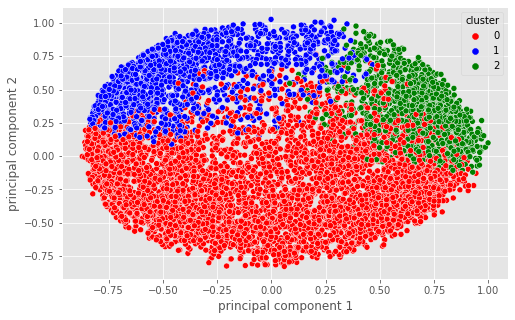

In [17]:
# Kmeans algorithm
kmean= KMeans(n_clusters=3,init='k-means++',n_init=10)
kmean.fit(scaled_df)
labels=kmean.labels_


# feature scaling for visualization
scaler = StandardScaler() 
scaled = scaler.fit_transform(df) 

# Normalizing the Data 
normalized_df = normalize(scaled) 
  
# Converting the numpy array into a pandas DataFrame 
normalized_df = pd.DataFrame(normalized_df)

# PCA to transform data to 2 dimensions for visualization
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(normalized_df)
principalDf = pd.DataFrame(data = principalComponents, columns=['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, pd.DataFrame({'cluster':labels})], axis = 1)

# scatterplot
plt.figure(figsize=(8,5))
ax = sns.scatterplot(x="principal component 1", y="principal component 2", hue="cluster", data=finalDf,palette=['red','blue','green'])
plt.show()

In [ ]:
pca_df = prepare_pca(3, normalized_df, labels)
plot_3d(pca_df)

In [18]:
clusters=pd.concat([df, pd.DataFrame({'cluster':labels})], axis=1)
clusters['cluster'].value_counts()

0    6103
1    1592
2    1255
Name: cluster, dtype: int64

In [19]:
clusters.groupby('cluster').mean()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
cluster,,,,,,,,,,,,,,,,,
0,799.978817,0.834678,501.123982,249.499466,251.946154,331.363177,0.463222,0.130349,0.344643,0.068489,1.215140,8.571522,3264.749801,908.810959,550.234248,0.154988,11.477470
1,3996.477236,0.958398,385.744504,249.355113,136.467073,3874.329830,0.233450,0.111221,0.145233,0.447689,12.407035,5.642588,6692.904865,3019.214513,1792.863399,0.033231,11.354899
2,2197.121297,0.981483,4228.062430,2695.335371,1533.205147,454.704300,0.948160,0.668854,0.738761,0.062812,1.521116,56.062151,7685.617530,4110.418079,1213.012276,0.300358,11.917131


Text(0.5, 0, 'SEGMENTS')

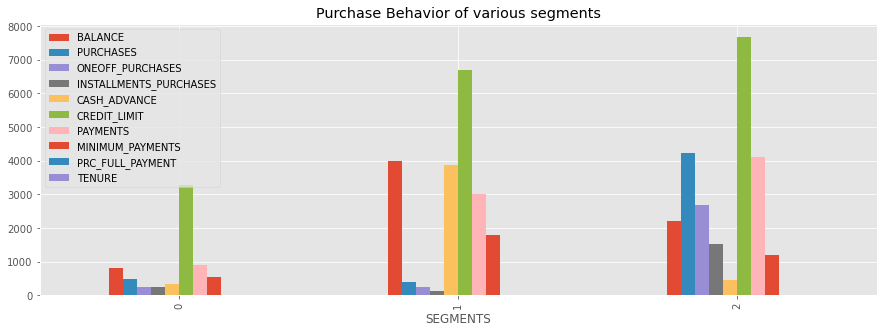

In [20]:
(clusters[['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES',
           'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE','CREDIT_LIMIT', 'PAYMENTS', 
           'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT','TENURE', 'cluster']]
 .groupby('cluster').mean().plot.bar(figsize=(15, 5)))
plt.title('Purchase Behavior of various segments')
plt.xlabel('SEGMENTS')